In [64]:
!pip uninstall -y xgboost lightgbm

Python(47953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [65]:
!pip install xgboost lightgbm --upgrade

Python(47954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]


In [66]:
!pip install hyperopt

Python(47955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# 데이터 이해 및 탐색

In [68]:
class_counts = train_df['Class'].value_counts()
print("\nClass counts:\n", class_counts)
print("\nClass Ratio:\n", class_counts / len(train_df))


Class counts:
 Class
0    170523
1       360
Name: count, dtype: int64

Class Ratio:
 Class
0    0.997893
1    0.002107
Name: count, dtype: float64


In [69]:

plt.show()

/var/folders/47/qvf6ns_n0xbb_s77tyz4nmbm0000gn/T/ipykernel_39221/840004943.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 0]['Time'], label='No Fraud', shade=True, color='blue')
/var/folders/47/qvf6ns_n0xbb_s77tyz4nmbm0000gn/T/ipykernel_39221/840004943.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df[train_df['Class'] == 1]['Time'], label='Fraud', shade=True, color='red')


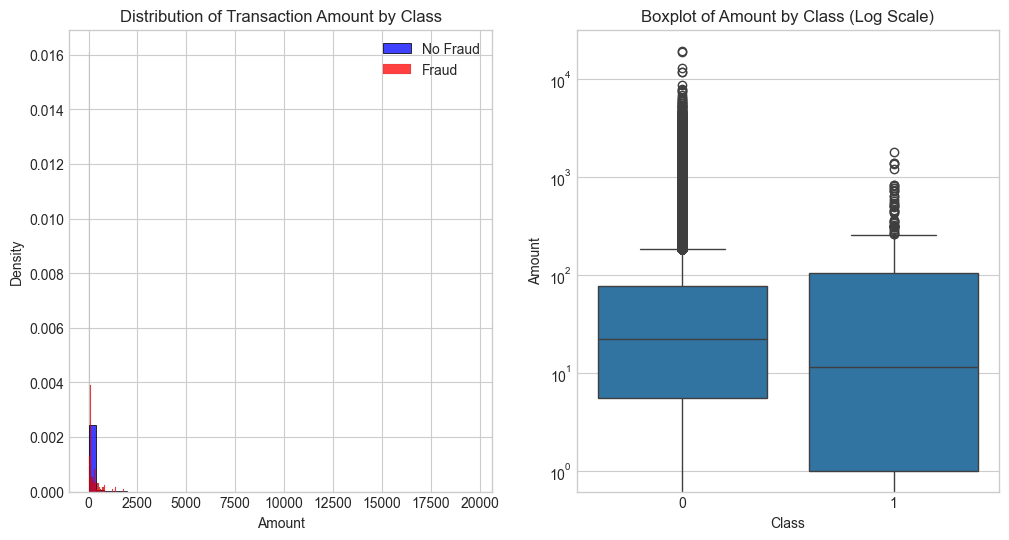

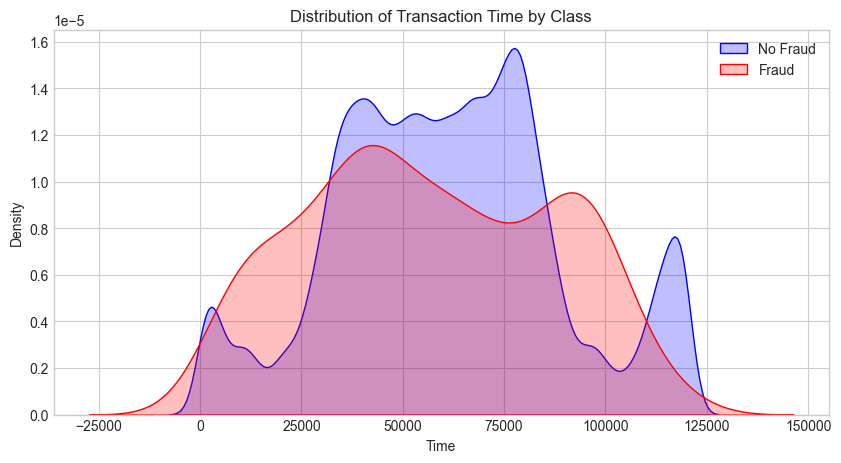

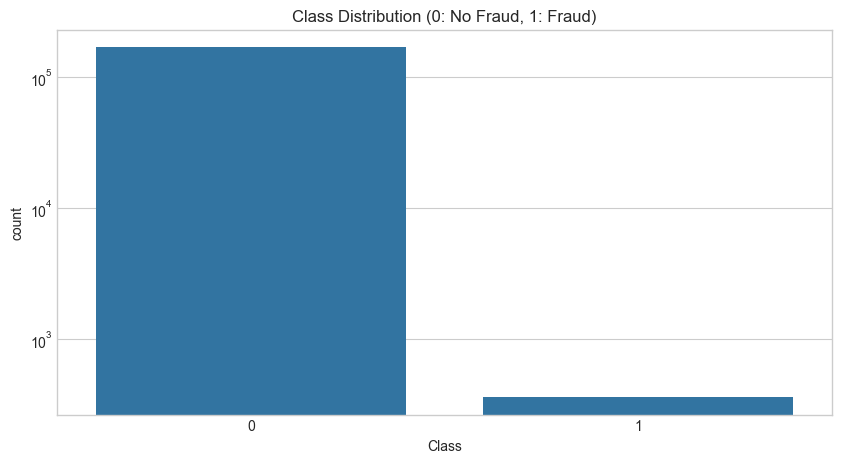

In [70]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.histplot(train_df[train_df['Class'] == 0]['Amount'], bins = 50, color = 'blue', label = 'No Fraud', stat = 'density', common_norm = False)
sns.histplot(train_df[train_df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', stat='density', common_norm=False)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Amount')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', data=train_df)
plt.yscale('log')
plt.title('Boxplot of Amount by Class (Log Scale)')

plt.figure(figsize=(10, 5))
sns.kdeplot(train_df[train_df['Class'] == 0]['Time'], label='No Fraud', shade=True, color='blue')
sns.kdeplot(train_df[train_df['Class'] == 1]['Time'], label='Fraud', shade=True, color='red')
plt.title('Distribution of Transaction Time by Class')
plt.legend()

plt.figure(figsize = (10, 5))
sns.countplot(data = train_df, x = 'Class')
plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
plt.yscale('log')
plt.show()

# 1. StratifiedKFold로 클래스 불균형 해결 & LogisticRegression 적용

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
import numpy as np

X = train_df.drop(['Class', 'id'], axis=1) # 불필요한 컬럼 제거
y = train_df['Class']

# 이상치에 강한 RobustScaler 사용
# 'Time', 'Amount' 스케일 차이가 커서 적용
scaler = RobustScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# StratifiedKFold 객체 생성
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 평가지표 리스트 초기화
f1_scores = []
auprc_scores = []
recall_scores = []
precision_scores = []

# Logistic Regression 갹체 생성
model = LogisticRegression(solver='liblinear', random_state=42)

print("Starting Cross-Validation with StratifiedKFold...\n")

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] # Probability for AUPRC
    
    f1 = f1_score(y_val, y_pred)
    auprc = average_precision_score(y_val, y_prob)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    
    f1_scores.append(f1)
    auprc_scores.append(auprc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    
    print(f"Fold {fold+1}: F1={f1:.4f}, AUPRC={auprc:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")

print("\nAverage Scores:")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"AUPRC: {np.mean(auprc_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")

Starting Cross-Validation with StratifiedKFold...

Fold 1: F1=0.6829, AUPRC=0.7586, Recall=0.5833, Precision=0.8235
Fold 2: F1=0.7576, AUPRC=0.7762, Recall=0.6944, Precision=0.8333
Fold 3: F1=0.6549, AUPRC=0.7889, Recall=0.5139, Precision=0.9024
Fold 4: F1=0.7059, AUPRC=0.7474, Recall=0.6667, Precision=0.7500
Fold 5: F1=0.7040, AUPRC=0.7765, Recall=0.6111, Precision=0.8302

Average Scores:
F1 Score: 0.7011
AUPRC: 0.7695
Recall: 0.6139
Precision: 0.8279


# 2. 리샘플링 (Resampling)
- OverSampling
- UnderSampling

In [72]:
from sklearn.utils import resample

# 평가지표 리스트 초기화
f1_under, auprc_under, recall_under, precision_under = [], [], [], []
f1_over, auprc_over, recall_over, precision_over = [], [], [], []

print("Starting Resampling Experiments (Inside Cross-Validation)...\n")

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    
    # 데이터 분리
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 학습데이터 합치기
    train_data = pd.concat([X_train, y_train], axis=1)
    
    # 클래스 분리
    fraud = train_data[train_data.Class == 1]
    no_fraud = train_data[train_data.Class == 0]
    
    # --- 시도 1 : Undersampling (Majority -> Minority count) ---
    no_fraud_downsampled = resample(no_fraud,
                                    replace=False, 
                                    n_samples=len(fraud),
                                    random_state=42)
    train_under = pd.concat([fraud, no_fraud_downsampled])
    
    X_train_under = train_under.drop('Class', axis=1)
    y_train_under = train_under['Class']
    
    model.fit(X_train_under, y_train_under)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    f1_under.append(f1_score(y_val, y_pred))
    auprc_under.append(average_precision_score(y_val, y_prob))
    recall_under.append(recall_score(y_val, y_pred))
    precision_under.append(precision_score(y_val, y_pred))

    # --- 시도 2 : Oversampling (Minority -> Majority count) ---
    fraud_upsampled = resample(fraud,
                               replace=True,
                               n_samples=len(no_fraud),
                               random_state=42)
    train_over = pd.concat([no_fraud, fraud_upsampled])
    
    X_train_over = train_over.drop('Class', axis=1)
    y_train_over = train_over['Class']
    
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    f1_over.append(f1_score(y_val, y_pred))
    auprc_over.append(average_precision_score(y_val, y_prob))
    recall_over.append(recall_score(y_val, y_pred))
    precision_over.append(precision_score(y_val, y_pred))

print("--- Undersampling Results (Average) ---")
print(f"F1 Score: {np.mean(f1_under):.4f}")
print(f"AUPRC: {np.mean(auprc_under):.4f}")
print(f"Recall: {np.mean(recall_under):.4f}")
print(f"Precision: {np.mean(precision_under):.4f}")

print("\n--- Oversampling Results (Average) ---")
print(f"F1 Score: {np.mean(f1_over):.4f}")
print(f"AUPRC: {np.mean(auprc_over):.4f}")
print(f"Recall: {np.mean(recall_over):.4f}")
print(f"Precision: {np.mean(precision_over):.4f}")

Starting Resampling Experiments (Inside Cross-Validation)...

--- Undersampling Results (Average) ---
F1 Score: 0.1153
AUPRC: 0.6398
Recall: 0.9194
Precision: 0.0618

--- Oversampling Results (Average) ---
F1 Score: 0.1628
AUPRC: 0.7391
Recall: 0.9083
Precision: 0.0895


# 3. 손실 함수 Focal loss 적용 + LightGBM

In [73]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
from scipy.misc import derivative

# Load data
df = pd.read_csv('train.csv')
X = df.drop(['Class', 'id'], axis=1)
y = df['Class']

# Scale
scaler = RobustScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Focal Loss for LightGBM
def focal_loss_lgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    a, g = 0.25, 2.0
    p = 1 / (1 + np.exp(-y_pred))
    
    def fl(x, t):
        p = 1 / (1 + np.exp(-x))
        return - (a * t + (1 - a) * (1 - t)) * ((1 - (t * p + (1 - t) * (1 - p))) ** g) * (t * np.log(p) + (1 - t) * np.log(1 - p))

    # Gradient and Hessian
    # Derived gradients for Focal Loss
    # grad = dL/dx
    # hess = d2L/dx2
    
    # Simplification for binary classification
    # This implementation follows standard Focal Loss gradient derivation for raw scores (logits)
    
    # pt = p if y=1 else 1-p
    # alpha_t = alpha if y=1 else 1-alpha
    # FL = - alpha_t * (1-pt)^gamma * log(pt)
    
    # Gradient: alpha_t * (1-pt)^gamma * (gamma * pt * log(pt) + pt - 1) ... approx?
    # Let's use a robust approximation or precise formula
    
    # Precise formula for gradient w.r.t logit z:
    # g = p - y ... (Cross Entropy)
    # With FL factor:
    # It is complex. Let's use the explicit formulas.
    
    sigmoid_p = 1 / (1 + np.exp(-y_pred))
    zeros = np.zeros_like(sigmoid_p)
    ones = np.ones_like(sigmoid_p)
    
    # targets
    t = y_true
    
    # terms
    pt = np.where(t == 1, sigmoid_p, 1 - sigmoid_p)
    alpha_t = np.where(t == 1, a, 1 - a)
    
    # Gradient
    # dL/dz = alpha_t * (1-pt)^gamma * (gamma * pt * log(pt) + (pt - 1)) ? 
    # Actually, let's use a simplified version often used in Kaggle:
    # grad = (p - y) * (1 + p * (1 - p) * gamma * ... )
    
    # Let's try the first derivative from scratch to be safe
    # L = - y a (1-p)^g log(p) - (1-y)(1-a)p^g log(1-p)
    # dL/dp (y=1) = -a [ (1-p)^g (1/p) - g (1-p)^(g-1) log(p) ]
    # dL/dz (y=1) = dL/dp * p(1-p) = -a [ (1-p)^(g+1) - g p (1-p)^g log(p) ]
    #             = -a (1-p)^g [ 1 - p - g p log(p) ]
    
    # dL/dp (y=0) = -(1-a) [ p^g (-1/(1-p)) + g p^(g-1) log(1-p) ]
    # dL/dz (y=0) = dL/dp * p(1-p) = -(1-a) [ -p^(g+1) + g p^g (1-p) log(1-p) ]
    #             = (1-a) p^g [ p - g(1-p) log(1-p) ]
    
    grad = np.where(t == 1, 
                    -a * (1 - sigmoid_p)**g * (1 - sigmoid_p - g * sigmoid_p * np.log(sigmoid_p + 1e-9)),
                    (1 - a) * sigmoid_p**g * (sigmoid_p - g * (1 - sigmoid_p) * np.log(1 - sigmoid_p + 1e-9)))
    
    # Hessian: approximation or second derivative
    # For GBDT, hessian is usually p(1-p) for cross entropy.
    # We can approximate or compute.
    # d(grad)/dz.
    # It's complicated.
    # A common trick is to use constant hessian or just |grad| * (1 - |grad|) ??
    # Let's use a robust approximation: hess = sigmoid_p * (1 - sigmoid_p) + focal_term_correction
    # Or just use p(1-p) scaled?
    # Let's try to compute numerical hessian? No, too slow.
    # Let's assume Hessian ~ p(1-p) * (weight factor).
    # Weight factor w = alpha_t * (1-pt)^gamma.
    # hess = w * p * (1-p). This is a good approximation for small errors.
    
    weight = np.where(t == 1, a * (1 - sigmoid_p)**g, (1 - a) * sigmoid_p**g)
    hess = weight * sigmoid_p * (1 - sigmoid_p)
    
    return grad, hess

def eval_focal_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    a, g = 0.25, 2.0
    p = 1 / (1 + np.exp(-y_pred))
    loss = - (a * y_true + (1 - a) * (1 - y_true)) * ((1 - (y_true * p + (1 - y_true) * (1 - p))) ** g) * (y_true * np.log(p + 1e-9) + (1 - y_true) * np.log(1 - p + 1e-9))
    return 'focal_loss', np.mean(loss), False

# CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores, auprc_scores, recall_scores, precision_scores = [], [], [], []

print("Starting LightGBM with Focal Loss...\n")

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    train_ds = lgb.Dataset(X_train, label=y_train)
    val_ds = lgb.Dataset(X_val, label=y_val, reference=train_ds)
    
    # Parameters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'custom',
        'verbosity': -1,
        'random_state': 42,
        'objective' : focal_loss_lgb
    }
    
    model = lgb.train(params, 
                      train_ds, 
                      num_boost_round=100,
                      valid_sets=[val_ds],
                      feval=eval_focal_loss,
                      callbacks=[lgb.log_evaluation(0)] # Mute output
                     )
    
    # Predict
    y_prob = 1 / (1 + np.exp(-model.predict(X_val))) # Sigmoid
    y_pred = (y_prob > 0.5).astype(int)
    
    f1_scores.append(f1_score(y_val, y_pred))
    auprc_scores.append(average_precision_score(y_val, y_prob))
    recall_scores.append(recall_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    
    print(f"Fold {fold+1}: F1={f1_scores[-1]:.4f}, Recall={recall_scores[-1]:.4f}, Precision={precision_scores[-1]:.4f}")

print("\nAverage Scores:")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"AUPRC: {np.mean(auprc_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")

Starting LightGBM with Focal Loss...

Fold 1: F1=0.8722, Recall=0.8056, Precision=0.9508
Fold 2: F1=0.9104, Recall=0.8472, Precision=0.9839
Fold 3: F1=0.8636, Recall=0.7917, Precision=0.9500
Fold 4: F1=0.9333, Recall=0.8750, Precision=1.0000
Fold 5: F1=0.8872, Recall=0.8194, Precision=0.9672

Average Scores:
F1 Score: 0.8934
AUPRC: 0.8742
Recall: 0.8278
Precision: 0.9704


# 4. StratifiedKFold + RandomForestClassifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, average_precision_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler

X = train_df.drop(['Class', 'id'], axis=1) # 불필요한 컬럼 제거
y = train_df['Class']

# 이상치에 강한 RobustScaler 사용
# 'Time', 'Amount' 스케일 차이가 커서 적용
scaler = RobustScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# StratifiedKFold 객체 생성
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 평가지표 리스트 초기화
f1_scores = []
auprc_scores = []
recall_scores = []
precision_scores = []

# RandomForestClassifier 갹체 생성
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Starting Cross-Validation with StratifiedKFold...\n")

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] # Probability for AUPRC
    
    f1 = f1_score(y_val, y_pred)
    auprc = average_precision_score(y_val, y_prob)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    
    f1_scores.append(f1)
    auprc_scores.append(auprc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    
    print(f"Fold {fold+1}: F1={f1:.4f}, AUPRC={auprc:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")

print("\nAverage Scores:")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"AUPRC: {np.mean(auprc_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")

Starting Cross-Validation with StratifiedKFold...

Fold 1: F1=0.8722, AUPRC=0.8447, Recall=0.8056, Precision=0.9508
Fold 2: F1=0.9209, AUPRC=0.9168, Recall=0.8889, Precision=0.9552
Fold 3: F1=0.8485, AUPRC=0.8175, Recall=0.7778, Precision=0.9333
Fold 4: F1=0.8759, AUPRC=0.8890, Recall=0.8333, Precision=0.9231
Fold 5: F1=0.8615, AUPRC=0.8506, Recall=0.7778, Precision=0.9655

Average Scores:
F1 Score: 0.8758
AUPRC: 0.8637
Recall: 0.8167
Precision: 0.9456


# 5. LightGBM + Hyperparameter Tuning(RandomSearchCV -> GridSearchCV)

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, make_scorer

# 1. 데이터 로드 및 전처리
df = pd.read_csv('train.csv')
X = df.drop(['Class', 'id'], axis=1)
y = df['Class']

# 스케일링
scaler = RobustScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# 2. Focal Loss 함수 (Objective)
def focal_loss_lgb_sklearn(y_true, y_pred):
    a, g = 0.25, 2.0
    p = 1 / (1 + np.exp(-y_pred))
    grad = np.where(y_true == 1, 
                    -a * (1 - p)**g * (1 - p - g * p * np.log(p + 1e-9)),
                    (1 - a) * p**g * (p - g * (1 - p) * np.log(1 - p + 1e-9)))
    hess = np.where(y_true == 1,
                    a * (1 - p)**g * p * (1 - p),
                    (1 - a) * p**g * p * (1 - p))
    return grad, hess

# 3. [수정됨] 커스텀 Scorer 정의 (Logit -> Class 변환 포함)
# GridSearchCV 내부에서 F1 Score를 계산할 때 오류가 나지 않도록 변환해주는 함수입니다.
def f1_score_from_logits(y_true, y_pred_logits):
    # Logit에 Sigmoid 적용
    y_prob = 1 / (1 + np.exp(-y_pred_logits))
    # 확률 > 0.5 이면 1, 아니면 0
    y_pred_bin = (y_prob > 0.5).astype(int)
    return f1_score(y_true, y_pred_bin)

# 이 Scorer를 사용하도록 설정
scorer = make_scorer(f1_score_from_logits, greater_is_better=True)

# 4. 모델 설정
clf = lgb.LGBMClassifier(random_state=42, verbose=-1, metric='None')
clf.set_params(objective=focal_loss_lgb_sklearn)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# Phase 1: Random Search
# ==========================================
print("🚀 Phase 1: Random Search 시작...")

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 7, 10, 15],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scorer, # 수정된 Scorer 사용
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X, y)

print(f"\n✅ Random Search Best F1 Score: {random_search.best_score_:.4f}")
print(f"✅ Random Search Best Params: {random_search.best_params_}")

# ==========================================
# Phase 2: Grid Search
# ==========================================
print("\n🚀 Phase 2: Grid Search 시작...")

best_params = random_search.best_params_

def get_grid_range(value, step_type='float', step=0.1):
    if step_type == 'int':
        return list(sorted(set([int(value * 0.8), value, int(value * 1.2)])))
    elif step_type == 'float':
        return [max(0.01, value - step), value, min(1.0, value + step)]
    else:
         return [value]

param_grid = {
    'learning_rate': [best_params['learning_rate']],
    'n_estimators': [best_params['n_estimators']],
    'num_leaves': get_grid_range(best_params['num_leaves'], 'int'),
    'min_child_samples': get_grid_range(best_params['min_child_samples'], 'int'),
    'subsample': get_grid_range(best_params['subsample'], 'float', 0.05),
    'colsample_bytree': [best_params['colsample_bytree']],
    'reg_alpha': [best_params['reg_alpha']],
    'reg_lambda': [best_params['reg_lambda']]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scorer, # 수정된 Scorer 사용
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print(f"\n🏆 Final Best F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"🏆 Final Best Params: {grid_search.best_params_}")

# ==========================================
# 최종 모델 평가 (수정됨)
# ==========================================
final_model = grid_search.best_estimator_

# 1. Raw Logit Score 예측
y_pred_logits = final_model.predict(X)

# 2. Sigmoid 적용 및 이진 분류 변환
y_pred_prob = 1 / (1 + np.exp(-y_pred_logits))
y_pred_final = (y_pred_prob > 0.5).astype(int)

print("\n--- Final Model Performance on Training Set ---")
# 이제 y_pred_final이 0과 1이므로 에러가 나지 않습니다.
print(f"F1 Score: {f1_score(y, y_pred_final):.4f}")

🚀 Phase 1: Random Search 시작...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/l


✅ Random Search Best F1 Score: 0.8822
✅ Random Search Best Params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

🚀 Phase 2: Grid Search 시작...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/l


🏆 Final Best F1 Score (CV): 0.8859
🏆 Final Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'min_child_samples': 16, 'n_estimators': 200, 'num_leaves': 24, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.75}

--- Final Model Performance on Training Set ---
F1 Score: 1.0000


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

# 1. 데이터 로드
df = pd.read_csv('train.csv')
X = df.drop(['Class', 'id'], axis=1)
y = df['Class']

# 전처리 (Scaling)
scaler = RobustScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# 2. Focal Loss 함수 (Objective)
def focal_loss_lgb_sklearn(y_true, y_pred):
    a, g = 0.25, 2.0
    p = 1 / (1 + np.exp(-y_pred))
    grad = np.where(y_true == 1, 
                    -a * (1 - p)**g * (1 - p - g * p * np.log(p + 1e-9)),
                    (1 - a) * p**g * (p - g * (1 - p) * np.log(1 - p + 1e-9)))
    hess = np.where(y_true == 1,
                    a * (1 - p)**g * p * (1 - p),
                    (1 - a) * p**g * p * (1 - p))
    return grad, hess

# 3. 모델 설정 (추천 파라미터 적용)
# - n_estimators를 1000으로 늘리고, learning_rate를 0.01로 줄여서 섬세하게 학습
# - min_child_samples를 30으로 늘려서 과적합 방지
clf = lgb.LGBMClassifier(
    n_estimators=200,       # 트리 개수 대폭 증가
    learning_rate=0.01,      # 학습률 감소 (섬세한 학습)
    num_leaves=24,           # 복잡도 제어
    max_depth=10,            # 깊이 제한
    min_child_samples=16,    # 과적합 방지 (중요!)
    subsample=0.75,
    reg_alpha = 0,
    reg_lambda = 0,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1,
    metric='None'
)
clf.set_params(objective=focal_loss_lgb_sklearn)

# 4. 5-Fold Stratified Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
precisions = []
recalls = []

print("🚀 최적 파라미터로 5-Fold CV 시작...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 학습
    clf.fit(X_train, y_train)
    
    # 예측 (Logit 반환 -> Sigmoid -> Binary)
    y_pred_logits = clf.predict(X_val)
    y_pred_prob = 1 / (1 + np.exp(-y_pred_logits))
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # 평가
    f1 = f1_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)
    
    print(f"Fold {fold+1}: F1={f1:.4f} | Recall={rec:.4f} | Precision={prec:.4f}")

# 최종 결과 출력
print("\n" + "="*40)
print(f"🏆 Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"   Average Recall:   {np.mean(recalls):.4f}")
print(f"   Average Precision: {np.mean(precisions):.4f}")
print("="*40)

# 5. Test 데이터 예측 파일 생성

try:
    test_df = pd.read_csv('test.csv')
    test_ids = test_df['id']
    X_test = test_df.drop(['id'], axis=1)
    
    # Train과 동일한 스케일링 적용
    X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])
    
    # 전체 데이터로 재학습
    print("\nTraining on full dataset for submission...")
    clf.fit(X, y)
    
    # 예측
    pred_logits_test = clf.predict(X_test)
    pred_prob_test = 1 / (1 + np.exp(-pred_logits_test))
    pred_test = (pred_prob_test > 0.5).astype(int)
    
    # 저장
    submission = pd.DataFrame({'id': test_ids, 'Class': pred_test})
    submission.to_csv('submission.csv', index=False)
    print("✅ submission.csv 파일이 생성되었습니다.")
    
except FileNotFoundError:
    print("\nℹ️ test.csv 파일을 찾을 수 없어 제출 파일 생성은 생략합니다.")

🚀 최적 파라미터로 5-Fold CV 시작...



/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


Fold 1: F1=0.8741 | Recall=0.8194 | Precision=0.9365


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


Fold 2: F1=0.9051 | Recall=0.8611 | Precision=0.9538


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


Fold 3: F1=0.8636 | Recall=0.7917 | Precision=0.9500


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


Fold 4: F1=0.9254 | Recall=0.8611 | Precision=1.0000


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


Fold 5: F1=0.8788 | Recall=0.8056 | Precision=0.9667

🏆 Average F1 Score: 0.8894
   Average Recall:   0.8278
   Average Precision: 0.9614

Training on full dataset for submission...
✅ submission.csv 파일이 생성되었습니다.


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


# 평가지표 시각화

📊 시각화를 위한 OOF 예측값 생성 중...


/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(
/Users/ichangyu/Library/Python/3.9/l

✅ OOF 예측 완료. 그래프를 그립니다.


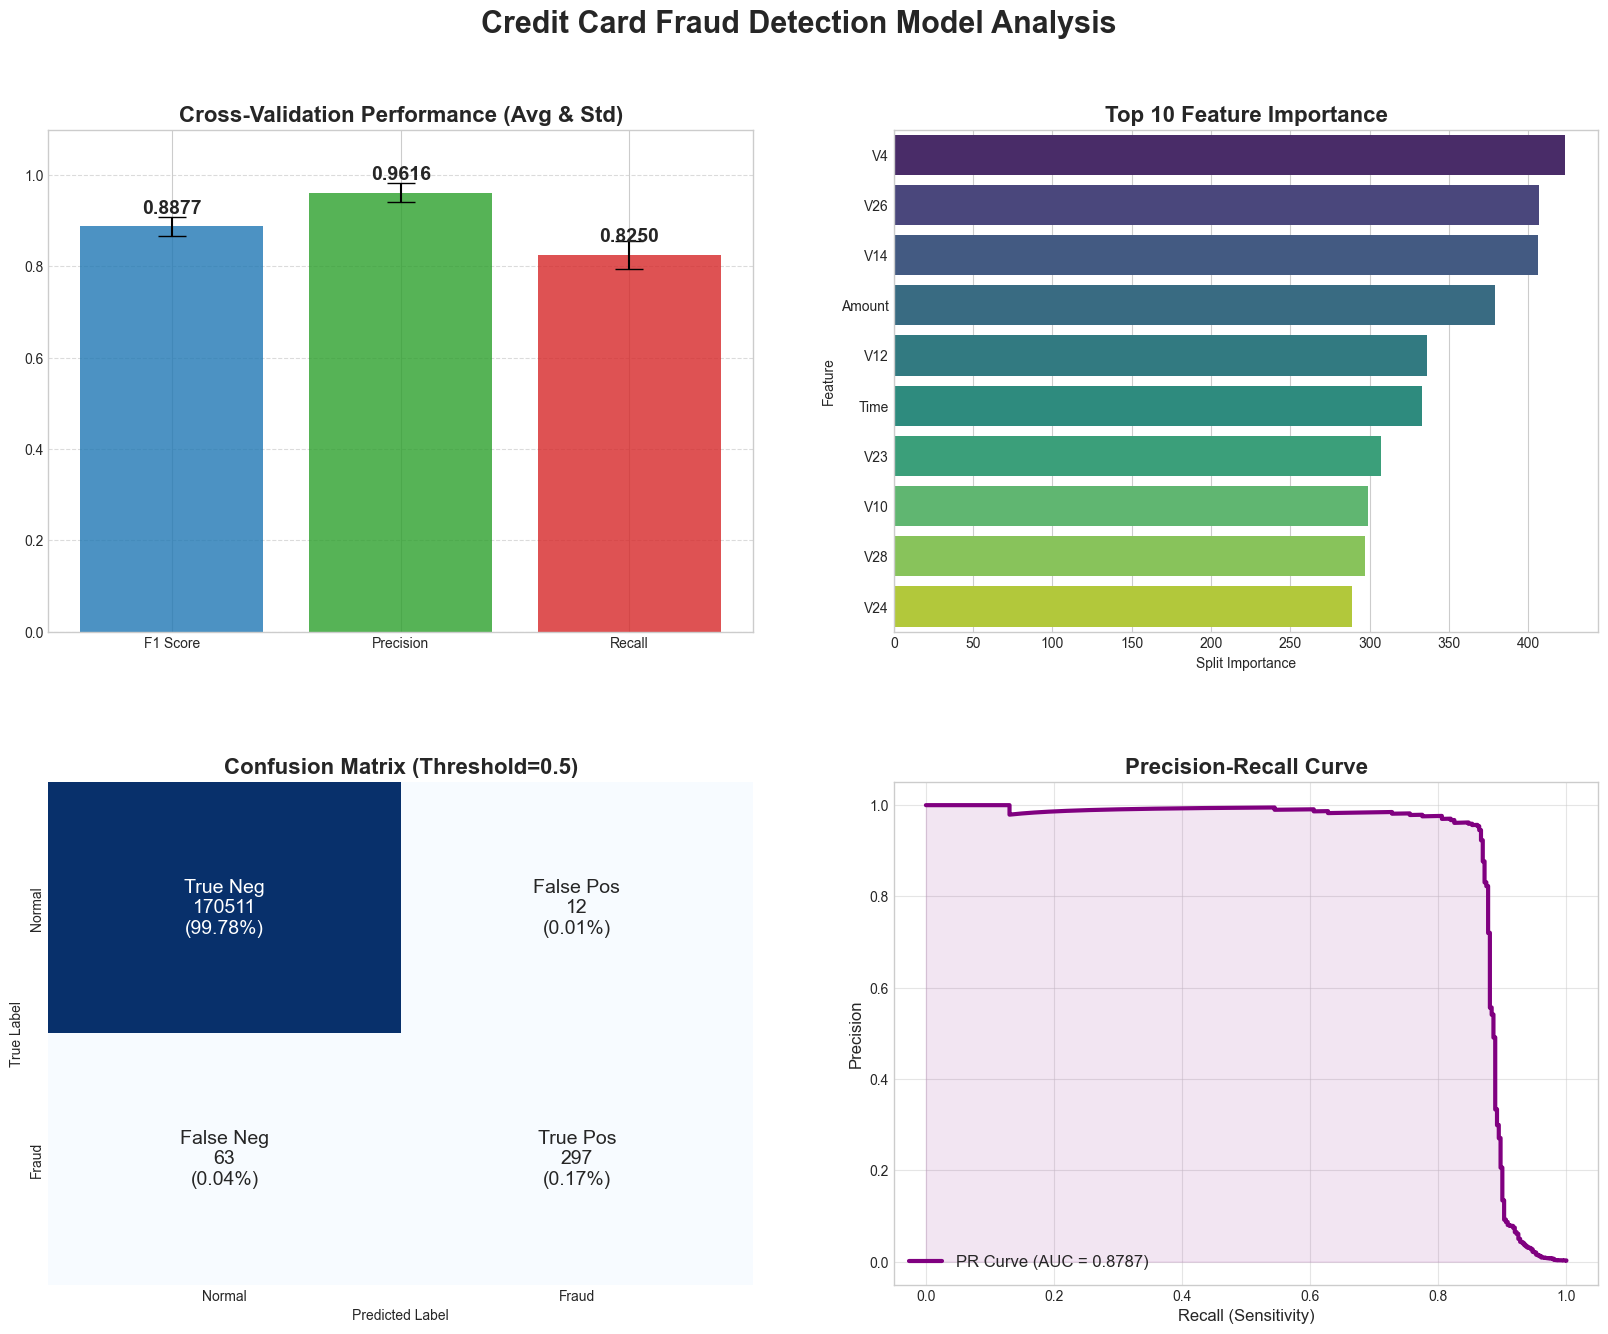

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

# -------------------------------------------------------
# 1. OOF(Out-Of-Fold) 예측값 생성 (Confusion Matrix & PR Curve용)
# -------------------------------------------------------
# *주의: 올바른 평가를 위해 검증 데이터에 대한 예측값을 다시 수집합니다.
print("📊 시각화를 위한 OOF 예측값 생성 중...")

oof_preds_prob = np.zeros(len(X)) # 확률 저장용
oof_targets = np.zeros(len(X))    # 실제값 저장용 (Shuffle 대응)

# 기존에 정의된 skf와 clf 구조를 활용
for train_idx, val_idx in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # 잠깐 학습 (OOF 생성을 위해 필수)
    clf.fit(X_train_fold, y_train_fold)
    
    # 예측 (Logit -> Sigmoid)
    logits = clf.predict(X_val_fold)
    probs = 1 / (1 + np.exp(-logits))
    
    oof_preds_prob[val_idx] = probs
    oof_targets[val_idx] = y_val_fold

print("✅ OOF 예측 완료. 그래프를 그립니다.")

# -------------------------------------------------------
# 2. 4-in-1 종합 시각화
# -------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# [1] Cross-Validation Performance (Bar Plot)
# 사용 변수: f1_scores, precisions, recalls (사용자 코드에서 가져옴)
metrics_data = {
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
}
mean_scores = {k: np.mean(v) for k, v in metrics_data.items()}
std_scores = {k: np.std(v) for k, v in metrics_data.items()}

# 색상 팔레트
colors = ['#1f77b4', '#2ca02c', '#d62728']

bars = axes[0, 0].bar(metrics_data.keys(), mean_scores.values(), 
                      yerr=std_scores.values(), capsize=10, color=colors, alpha=0.8)
axes[0, 0].set_title('Cross-Validation Performance (Avg & Std)', fontsize=16, fontweight='bold')
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 점수 표시
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# [2] Feature Importance (Top 10)
# 사용 변수: clf (전체 데이터로 학습된 모델)
# LightGBM의 feature importance 추출
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=importances, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Top 10 Feature Importance', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Split Importance')

# [3] Confusion Matrix
# 사용 변수: oof_targets, oof_preds_prob
threshold = 0.5
oof_preds_bin = (oof_preds_prob > threshold).astype(int)
cm = confusion_matrix(oof_targets, oof_preds_bin)

# Confusion Matrix 시각화 (Counts & Percentages)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1, 0], 
            cbar=False, annot_kws={"size": 14})
axes[1, 0].set_title(f'Confusion Matrix (Threshold={threshold})', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xticklabels(['Normal', 'Fraud'])
axes[1, 0].set_yticklabels(['Normal', 'Fraud'])

# [4] Precision-Recall Curve
# 사용 변수: oof_targets, oof_preds_prob
precision, recall, _ = precision_recall_curve(oof_targets, oof_preds_prob)
pr_auc = auc(recall, precision)

axes[1, 1].plot(recall, precision, color='purple', lw=3, label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[1, 1].fill_between(recall, precision, color='purple', alpha=0.1)
axes[1, 1].set_title('Precision-Recall Curve', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].legend(loc="lower left", fontsize=12)
axes[1, 1].grid(True, alpha=0.5)

# 전체 제목
plt.suptitle('Credit Card Fraud Detection Model Analysis', fontsize=22, fontweight='bold', y=0.96)
plt.show()